<h1><center>Titanic Machine Learning Project</center></h1>

In [1]:
from jupyterthemes import get_themes
from jupyterthemes.stylefx import set_nb_theme
set_nb_theme('chesterish')

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In this project, I am attempting to make a classification model that predicts whether or not a passenger on the Titanic survived based on the following features (independent variables):

    Description ==> variable name

    Ticket class of the passenger ==> 'Pclass'
    Gender of the passenger ==> 'Sex'
    Number of siblings/spouses to the passenger aboard ==> 'SibSp'
    Number of parents/children to the passenger aboard ==> 'Parch'
    Which port the passenger embarked from ==> 'Embarked'
    The social status of the passenger ==> 'Title'
    The cabin section of the passenger ==> 'Cabin_section'
    
The target (dependent variable) is whether or not the passenger survived the disaster.  I took several steps to examine and clean the provided data, as well as train and fit the data to several different classification models (listed below):

    Models fit to the data:

    K Nearest Neighbors
    Logistic Regression
    Decision Tree
    Random Forest
    Voting Classifier of the 4 aforementioned models

Ultimately, I decided that of the models that I fit to this data the most effective model for predicting whether or not a passenger survived is a <Italic> _Logistic Regression model_.  The <Italic> _Logistic Regression model_ not only yielded the highest <Bold> __accuracy__ on the test dataset, it also yielded the highest <Bold> __f1 score__ (which is the average of the <Bold> __precision__ and the <Bold> __recall__)

In [3]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

# Gathering the data

In [4]:
# Downloaded the data from Kaggle onto my laptop and imported it from there

path = '/Users/johnathonspilker 1/Documents/kaggle/titanic/data'
files = os.listdir(path)

In [5]:
df_dependent = pd.read_csv(path + '/gender_submission.csv')
df1 = pd.read_csv(path + '/test.csv')
df2 = pd.read_csv(path + '/train.csv')

# display float values in dataframe with only 2 decimal points
pd.options.display.float_format = "{:,.2f}".format

    
The variable PassengerId from the train dataset (df2) is composed of passengers 1 through 891 and PassengerId from the test dataset (df1) is composed of passengers 892 through 1309.  For the purposes of this project, I want to practice using scikit-learn's train_test_split function to take a random set of 75% of the passengers for the training set. The remaining 25% of the passengers will be the test dataset.
    

In [6]:
# merge the training and test dataframes into one dataframe that will be split later

df_dep = df_dependent.merge(right = df1, how = 'inner', left_on = 'PassengerId', right_on = 'PassengerId')
df_comb = pd.concat([df_dep, df2], ignore_index = True)
df_comb = df_comb.sort_values('PassengerId')
df_comb = df_comb.set_index('PassengerId')

# Data exploration and cleaning

#### Before splitting the data, need to address the many missing values for Cabin and Age
#### Ticket also seems to have no consistent values/format

In [7]:
df_comb.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 1 to 1309
Data columns (total 11 columns):
Survived    1309 non-null int64
Pclass      1309 non-null int64
Name        1309 non-null object
Sex         1309 non-null object
Age         1046 non-null float64
SibSp       1309 non-null int64
Parch       1309 non-null int64
Ticket      1309 non-null object
Fare        1308 non-null float64
Cabin       295 non-null object
Embarked    1307 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 122.7+ KB


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1122313d0>]],
      dtype=object)

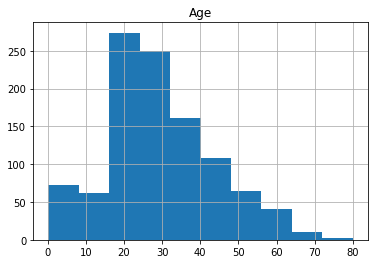

In [8]:
df_comb.hist('Age')

In [9]:
# since age has most of its entries and since I feel it should be kept, I'm filling its values with the mean
df_comb['Age']  = df_comb['Age'].fillna(df_comb['Age'].mean())

In [10]:
# the missing embarked values do not seem to be together or related because:
    # neither are a sibling, spouse, parent, or child to another person on the ship
    # their ages are very different
    # what is interesting however is that both entries have the same ticket number (even though there are many non-unique ticket numbers)
    
df_comb['embarked_bool'] = df_comb['Embarked'].isna()
df_comb[df_comb['embarked_bool'] == True]

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,embarked_bool
PassengerId,,,,,,,,,,,,
62,1,1,"Icard, Miss. Amelie",female,38.00,0,0,113572,80.00,B28,NaN,True
830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.00,0,0,113572,80.00,B28,NaN,True


In [11]:
df_comb['Embarked'].value_counts()

S    914
C    270
Q    123
Name: Embarked, dtype: int64

In [12]:
# fill nan values with most common embark location: S = Southampton
df_comb['Embarked'] = df_comb['Embarked'].fillna('S')
df_comb.drop(columns = ['embarked_bool'], inplace = True)

In [13]:
# Aside from one last item involving 'Fare' these look reasonable
# 'Fare' has a minimum value of 0, could be missing data marked as 0
# Scaling will be necessary for certain models
df_comb.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,"1,309.00","1,309.00","1,309.00","1,309.00","1,309.00","1,308.00"
mean,0.38,2.29,29.88,0.50,0.39,33.30
std,0.48,0.84,12.88,1.04,0.87,51.76
min,0.00,1.00,0.17,0.00,0.00,0.00
25%,0.00,2.00,22.00,0.00,0.00,7.90
50%,0.00,3.00,29.88,0.00,0.00,14.45
75%,1.00,3.00,35.00,1.00,0.00,31.27
max,1.00,3.00,80.00,8.00,9.00,512.33


In [14]:
df_comb['Sex'].value_counts()

male      843
female    466
Name: Sex, dtype: int64

In [15]:
# Due to seeming randomness in class and ticket I believe that the sample with a fare value of 0 are actually missing data
# The only consistencies are Embarked location and Sex being 'S' and 'male' respectively
# Both of these values are the most common entries for their respective variables

df_comb[df_comb['Fare'] == 0]

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
180,0,3,"Leonard, Mr. Lionel",male,36.00,0,0,LINE,0.00,NaN,S
264,0,1,"Harrison, Mr. William",male,40.00,0,0,112059,0.00,B94,S
272,1,3,"Tornquist, Mr. William Henry",male,25.00,0,0,LINE,0.00,NaN,S
278,0,2,"Parkes, Mr. Francis ""Frank""",male,29.88,0,0,239853,0.00,NaN,S
303,0,3,"Johnson, Mr. William Cahoone Jr",male,19.00,0,0,LINE,0.00,NaN,S
414,0,2,"Cunningham, Mr. Alfred Fleming",male,29.88,0,0,239853,0.00,NaN,S
467,0,2,"Campbell, Mr. William",male,29.88,0,0,239853,0.00,NaN,S
482,0,2,"Frost, Mr. Anthony Wood ""Archie""",male,29.88,0,0,239854,0.00,NaN,S
598,0,3,"Johnson, Mr. Alfred",male,49.00,0,0,LINE,0.00,NaN,S


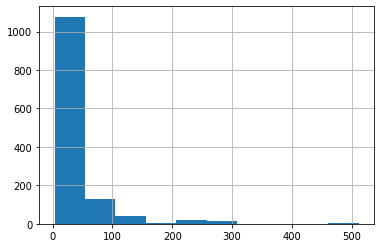

In [16]:
# replace 0 values in 'Fare' with NaN's and look at the distribution

df_comb['Fare'] = df_comb['Fare'].replace(0, np.nan)
df_comb['Fare'].hist()

In [17]:
# Fill it with the median due to its skewed distribution

df_comb['Fare'] = df_comb['Fare'].fillna(df_comb['Fare'].median())

In [18]:
# Next, I am adding a column based on the title of the people boarding

df_comb['Title'] = df_comb['Name'].apply(lambda x: x.split(',')[1])
df_comb['Title'] = df_comb['Title'].str.split(' ')
df_comb['Title'] = df_comb['Title'].apply(lambda x: x[1])
df_comb['Title'] = df_comb['Title'].replace('the', 'Countess')

In [19]:
# From the following table, it seems like more women (both single and married) survived
# Military personnel for the most part did not survive
# People of high social status (Count, Countess) survived
# No Reverands did not survive

title = df_comb[['Survived', 'Title']].groupby('Title').sum()
title['Total'] = df_comb['Title'].value_counts()
title['Survived_%'] = title['Survived'] / title['Total']
title['Survived_%']
title

,Survived,Total,Survived_%
Title,,,
Capt.,0,1,0.00
Col.,1,4,0.25
Countess,1,1,1.00
Don.,0,1,0.00
Dona.,1,1,1.00
Dr.,3,8,0.38
Jonkheer.,0,1,0.00
Lady.,1,1,1.00
Major.,1,2,0.50


In [20]:
# High correlations (|correlation| > 25%) exist between:
    # 'survived' and 'Pclass'
    # 'Age' and 'Pclass'
    # 'Pclass' and 'Fair'
    # 'Parch' and 'SibSp'
    
df_comb.corr()

,Survived,Pclass,Age,SibSp,Parch,Fare
Survived,1.00,-0.26,-0.05,0.00,0.11,0.23
Pclass,-0.26,1.00,-0.37,0.06,0.02,-0.56
Age,-0.05,-0.37,1.00,-0.19,-0.13,0.17
SibSp,0.00,0.06,-0.19,1.00,0.37,0.16
Parch,0.11,0.02,-0.13,0.37,1.00,0.22
Fare,0.23,-0.56,0.17,0.16,0.22,1.00


In [21]:
# took this idea from Ken Jee
# from this table, it APPEARS (need to test) as if people who paid a higher fare were more likely to survive
# and if the person had parents and/or children they appeared more likely to survive

pd.pivot_table(df_comb, index = 'Survived', values = ['Age', 'SibSp', 'Parch', 'Fare'])

,Age,Fare,Parch,SibSp
Survived,,,,
0,30.37,24.15,0.31,0.50
1,29.08,48.84,0.51,0.50


In [22]:
pd.set_option('display.max_rows', None)
df_comb['Cabin'].value_counts(dropna = False)

NaN                1014
C23 C25 C27           6
G6                    5
B57 B59 B63 B66       5
D                     4
C22 C26               4
F4                    4
F33                   4
B96 B98               4
F2                    4
C78                   4
E101                  3
C101                  3
A34                   3
B51 B53 B55           3
E34                   3
B58 B60               3
C2                    2
B77                   2
B69                   2
D37                   2
C62 C64               2
E33                   2
E25                   2
E24                   2
D10 D12               2
C126                  2
B49                   2
B20                   2
C31                   2
C65                   2
C89                   2
B22                   2
D36                   2
F G73                 2
D30                   2
D20                   2
C7                    2
D21                   2
C54                   2
D33                   2
C55 C57         

In [23]:
pd.set_option('display.max_rows', 10)

In [24]:
# Since cabin is a variable that I'd like to keep, decided to make the missing values their own 'class'

df_comb['Cabin_section'] = df_comb['Cabin'].astype('str').apply(lambda x: x[0])
df_comb['Cabin_section'] = df_comb['Cabin_section'].replace('n', 'NaN')

In [25]:
# Dropped variables that won't be used for modeling and changed the types of categorical variables to later use pd.get_dummies

df_comb.drop(columns = ['Cabin', 'Ticket', 'Name'], inplace = True)

df_comb['Survived'] = pd.Categorical(df_comb['Survived'])
df_comb['Pclass'] = pd.Categorical(df_comb['Pclass'])
df_comb['Sex'] = pd.Categorical(df_comb['Sex'])
df_comb['Embarked'] = pd.Categorical(df_comb['Embarked'])
df_comb['Title'] = pd.Categorical(df_comb['Title'])
df_comb['Cabin_section'] = pd.Categorical(df_comb['Cabin_section'])

In [26]:
X = df_comb.drop(columns = ['Survived'])
y = df_comb[['Survived']]

In [27]:
X = pd.get_dummies(X, drop_first = True)

# Analysis

In [28]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 271)

In [29]:
def pretty_confusion_matrix(confusion_matrix):
    display(pd.DataFrame(data = confusion_matrix,
                 index = pd.MultiIndex.from_product([['Actual Values'], ['Passed', 'Survived']]),
                 columns = pd.MultiIndex.from_product([['Predicted Values'], ['Passed', 'Survived']])))

    K Nearest Neighbors

In [30]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier

In [31]:
steps = [('scaler', StandardScaler()),
         ('knn', KNeighborsClassifier())]
pipeline = Pipeline(steps)

knn_model = pipeline.fit(X_train, y_train.values.ravel())
y_pred = knn_model.predict(X_test)

knn_conf = confusion_matrix(y_test, y_pred)
knn_report = classification_report(y_test, y_pred, target_names = ['Passed', 'Survived'])

print('KNN confusion matrix:')
pretty_confusion_matrix(confusion_matrix(y_test, y_pred))
print('KNN classification report:\n')
print(knn_report)

KNN confusion matrix:


Predicted Values         
                                 Passed Survived
Actual Values Passed                187       22
              Survived               28       91

KNN classification report:

              precision    recall  f1-score   support

      Passed       0.87      0.89      0.88       209
    Survived       0.81      0.76      0.78       119

    accuracy                           0.85       328
   macro avg       0.84      0.83      0.83       328
weighted avg       0.85      0.85      0.85       328



In [32]:
knn_cv_f1 = cross_val_score(knn_model, X_train, y_train.values.ravel(), cv = 5, scoring = 'f1')
print('CV f1: ' + str(knn_cv_f1.mean()))
knn_cv_acc = cross_val_score(knn_model, X_train, y_train.values.ravel(), cv = 5, scoring = 'accuracy')
print('CV accuracy: ' + str(knn_cv_acc.mean()))

CV f1: 0.8093167848699764
CV accuracy: 0.8603387547912567


In [33]:
knn_scores = {'accuracy': accuracy_score(y_pred, y_test),
              'precision': precision_score(y_pred, y_test),
              'recall': recall_score(y_pred, y_test),
              'f1_score': f1_score(y_pred, y_test),
              'cv accuracy': knn_cv_acc.mean(),
              'cv f1_score': knn_cv_f1.mean()}

    Logistic Regression

In [34]:
from sklearn.linear_model import LogisticRegression

In [35]:
# Logistic Regression has a good R^2 value
# Increased max iterations on suggestion of an error message 
steps = [('scaler', StandardScaler()),
         ('lr', LogisticRegression())]
pipeline = Pipeline(steps)

lr_model = pipeline.fit(X_train, y_train.values.ravel())
y_pred = lr_model.predict(X_test)

lr_conf = confusion_matrix(y_test, y_pred)
lr_report = classification_report(y_test, y_pred, target_names = ['Passed', 'Survived'])

print('logistic regression confusion matrix: \n')
pretty_confusion_matrix(lr_conf)
print('logistic regression classification report: \n')
print(lr_report)

logistic regression confusion matrix: 



Predicted Values         
                                 Passed Survived
Actual Values Passed                187       22
              Survived               26       93

logistic regression classification report: 

              precision    recall  f1-score   support

      Passed       0.88      0.89      0.89       209
    Survived       0.81      0.78      0.79       119

    accuracy                           0.85       328
   macro avg       0.84      0.84      0.84       328
weighted avg       0.85      0.85      0.85       328



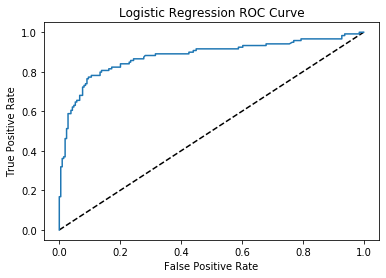

In [36]:
# Take a look at the ROC curve to see the relationship between the true positive rate and the false positive rate

from sklearn.metrics import roc_curve
y_pred_prob = lr_model.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Logistic Regression')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression ROC Curve')
plt.show();

In [37]:
# Cross validation for logistic regression

lr_cv_f1 = cross_val_score(lr_model, X_train, y_train.values.ravel(), cv = 5, scoring = 'f1')
print('logistic regression CV f1: ' + str(lr_cv_f1.mean()))
lr_cv_acc = cross_val_score(lr_model, X_train, y_train.values.ravel(), cv = 5, scoring = 'accuracy')
print('logistic regression CV accuracy: ' + str(lr_cv_acc.mean()))

logistic regression CV f1: 0.8246934081317564
logistic regression CV accuracy: 0.8705376566870402


In [38]:
lr_scores =  {'accuracy': accuracy_score(y_pred, y_test),
              'precision': precision_score(y_pred, y_test),
              'recall': recall_score(y_pred, y_test),
              'f1_score': f1_score(y_pred, y_test),
              'cv accuracy': lr_cv_acc.mean(),
              'cv f1_score': lr_cv_f1.mean()}

    Decision Tree

In [39]:
# want to improve these score

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
dt_model = DecisionTreeClassifier(criterion = 'gini', random_state = 42)
dt_model.fit(X_train, y_train)
y_pred = dt_model.predict(X_test)
print('Accuracy: ' + str(accuracy_score(y_test, y_pred)))
print('f1_score: ' + str(f1_score(y_test, y_pred)))

Accuracy: 0.7865853658536586
f1_score: 0.7286821705426356


In [40]:
# Next conduct 2 grid searches to try and maximze both accuracy and the f1 score

params_dt = {
             'max_depth' : [2, 3, 4, 5, 6, 7],
             'min_samples_leaf' : [0.1, 0.15, 0.2, 0.25],
             'max_features' : [0.2, 0.4, 0.6, 0.8, 1]
            }

In [41]:
# optimal grid search for f1 score

grid_dt_f1 = GridSearchCV(estimator = dt_model, param_grid = params_dt, scoring = 'f1', cv = 5, n_jobs = -1)
grid_dt_f1.fit(X_train, y_train)
print('Best hyperparameters for f1:\n', grid_dt_f1.best_params_)

y_pred = grid_dt_f1.predict(X_test)
print('f1 optimized accuracy score: ' + str(accuracy_score(y_pred, y_test)))
print('f1 optimized f1 score: ' + str(f1_score(y_pred, y_test)))


# optimal grid search for accuracy score

grid_dt_acc = GridSearchCV(estimator = dt_model, param_grid = params_dt, scoring = 'accuracy', cv = 5, n_jobs = -1)
grid_dt_acc.fit(X_train, y_train)
print('\nBest hyperparameters for accuracy:\n', grid_dt_acc.best_params_)

y_pred = grid_dt_acc.predict(X_test)
print('Accuracy optimized accuracy score: ' + str(accuracy_score(y_pred, y_test)))
print('Accuracy optimized f1 score: ' + str(f1_score(y_pred, y_test)))

Best hyperparameters for f1:
 {'max_depth': 2, 'max_features': 0.4, 'min_samples_leaf': 0.1}
f1 optimized accuracy score: 0.8445121951219512
f1 optimized f1 score: 0.7848101265822784

Best hyperparameters for accuracy:
 {'max_depth': 2, 'max_features': 0.4, 'min_samples_leaf': 0.1}
Accuracy optimized accuracy score: 0.8445121951219512
Accuracy optimized f1 score: 0.7848101265822784


In [42]:
# trees and scores appear identical.  using a visual for clarification

from sklearn.tree import plot_tree
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt

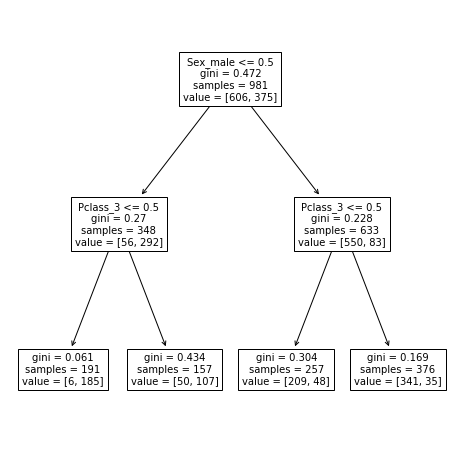

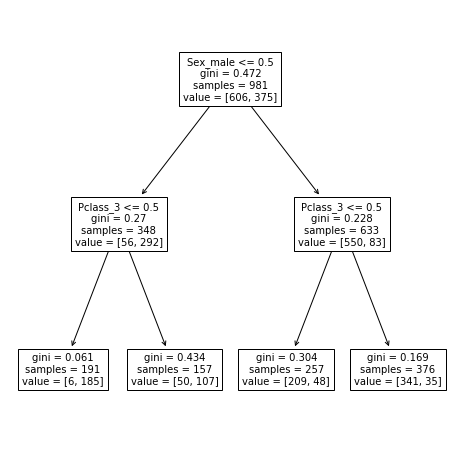

In [43]:
# the optimal trees for accuracy and the f1 score are identical

fig, ax = plt.subplots(figsize=(8, 8))
plot_tree(grid_dt_acc.best_estimator_, feature_names = X.columns, fontsize = 10)
plt.show()
fig, ax = plt.subplots(figsize=(8, 8))
plot_tree(grid_dt_f1.best_estimator_, feature_names = X.columns, fontsize = 10)
plt.show()

In [44]:
dt_cv_f1 = cross_val_score(grid_dt_acc.best_estimator_, X_train, y_train.values.ravel(), cv = 5, scoring = 'f1')
print('decision tree CV f1 scores: ' + str(dt_cv_f1))
print('decision tree CV f1 mean: ' + str(dt_cv_f1.mean()))

dt_cv_acc = cross_val_score(grid_dt_acc.best_estimator_, X_train, y_train.values.ravel(), cv = 5, scoring = 'accuracy')
print('\ndecision tree CV accuracy scores: ' + str(dt_cv_acc))
print('decision tree CV accuracy mean: ' + str(dt_cv_acc.mean()))

decision tree CV f1 scores: [0.81578947 0.82191781 0.79411765 0.82432432 0.78014184]
decision tree CV f1 mean: 0.8072582194516335

decision tree CV accuracy scores: [0.85786802 0.86734694 0.85714286 0.86734694 0.84183673]
decision tree CV accuracy mean: 0.8583082979384647


In [45]:
dt_conf = confusion_matrix(y_test, y_pred)
dt_report = classification_report(y_test, y_pred, target_names = ['Passed', 'Survived'])

print('decision tree confusion matrix: \n')
pretty_confusion_matrix(dt_conf)
print('decision tree classification report: \n')
print(dt_report)

decision tree confusion matrix: 



Predicted Values         
                                 Passed Survived
Actual Values Passed                184       25
              Survived               26       93

decision tree classification report: 

              precision    recall  f1-score   support

      Passed       0.88      0.88      0.88       209
    Survived       0.79      0.78      0.78       119

    accuracy                           0.84       328
   macro avg       0.83      0.83      0.83       328
weighted avg       0.84      0.84      0.84       328



In [46]:
dt_scores =  {'accuracy': accuracy_score(y_pred, y_test),
              'precision': precision_score(y_pred, y_test),
              'recall': recall_score(y_pred, y_test),
              'f1_score': f1_score(y_pred, y_test),
              'cv accuracy': dt_cv_acc.mean(),
              'cv f1_score': dt_cv_f1.mean()}

    Random Forest

In [47]:
from sklearn.ensemble import RandomForestClassifier

In [48]:
rf_model = RandomForestClassifier(criterion = 'gini', random_state = 1618)
rf_model.fit(X_train, y_train.values.ravel())
y_pred = rf_model.predict(X_test)
print('Accuracy: ' + str(accuracy_score(y_test, y_pred)))
print('f1_score: ' + str(f1_score(y_test, y_pred)))

Accuracy: 0.8262195121951219
f1_score: 0.7594936708860759


In [49]:
params_rf = {
             'n_estimators' : [50, 75, 100, 125],
             'max_depth' : [2, 3, 4, 5],
             'min_samples_leaf' : [0.1, 0.15, 0.2],
             'max_features' : [0.2, 0.4, 0.6, 0.8, 1]
            }

In [50]:
# grid search optimized on f1 score

grid_rf_f1 = GridSearchCV(estimator = rf_model, param_grid = params_rf, scoring = 'f1', n_jobs = -1)
grid_rf_f1.fit(X_train, y_train.values.ravel())
print('Best hyperparameters for f1:\n', grid_rf_f1.best_params_)

y_pred = grid_rf_f1.predict(X_test)
print('F1 optimized f1 score: ' + str(f1_score(y_pred, y_test)))
print('F1 optimized accuracy score: ' + str(accuracy_score(y_pred, y_test)))

Best hyperparameters for f1:
 {'max_depth': 3, 'max_features': 0.2, 'min_samples_leaf': 0.1, 'n_estimators': 75}
F1 optimized f1 score: 0.7866108786610879
F1 optimized accuracy score: 0.8445121951219512


In [51]:
# grid search optimized on accuracy

grid_rf_acc = GridSearchCV(estimator = rf_model, param_grid = params_rf, scoring = 'accuracy', n_jobs = -1)
grid_rf_acc.fit(X_train, y_train.values.ravel())
print('Best hyperparameters for accuracy:\n', grid_rf_acc.best_params_)

y_pred = grid_rf_acc.predict(X_test)
print('Accuracy optimized f1 score: ' + str(f1_score(y_pred, y_test)))
print('Accuracy optimized accuracy score: ' + str(accuracy_score(y_pred, y_test)))

Best hyperparameters for accuracy:
 {'max_depth': 2, 'max_features': 0.2, 'min_samples_leaf': 0.1, 'n_estimators': 125}
Accuracy optimized f1 score: 0.7848101265822784
Accuracy optimized accuracy score: 0.8445121951219512


In [52]:
rf_cv_f1 = cross_val_score(grid_rf_acc.best_estimator_, X_train, y_train.values.ravel(), cv = 5, scoring = 'f1')
print('random forest CV f1 scores: ' + str(rf_cv_f1))
print('random forest CV f1 mean: ' + str(rf_cv_f1.mean()))

rf_cv_acc = cross_val_score(grid_rf_acc.best_estimator_, X_train, y_train.values.ravel(), cv = 5, scoring = 'accuracy')
print('\nrandom forest CV accuracy scores: ' + str(rf_cv_acc))
print('random forest CV accuracy: ' + str(rf_cv_acc.mean()))

random forest CV f1 scores: [0.81578947 0.82191781 0.79411765 0.82432432 0.78014184]
random forest CV f1 mean: 0.8072582194516335

random forest CV accuracy scores: [0.85786802 0.86734694 0.85714286 0.86734694 0.84183673]
random forest CV accuracy: 0.8583082979384647


In [53]:
# confusion matrix and classification report

In [54]:
rf_conf = confusion_matrix(y_test, y_pred)
rf_report = classification_report(y_test, y_pred, target_names = ['Passed', 'Survived'])

print('random forest confusion macrix: \n')
pretty_confusion_matrix(rf_conf)
print('random forest classification report: \n')
print(rf_report)

random forest confusion macrix: 



Predicted Values         
                                 Passed Survived
Actual Values Passed                184       25
              Survived               26       93

random forest classification report: 

              precision    recall  f1-score   support

      Passed       0.88      0.88      0.88       209
    Survived       0.79      0.78      0.78       119

    accuracy                           0.84       328
   macro avg       0.83      0.83      0.83       328
weighted avg       0.84      0.84      0.84       328



In [55]:
# scores on grid_rf_acc

rf_scores =  {'accuracy': accuracy_score(y_pred, y_test),
              'precision': precision_score(y_pred, y_test),
              'recall': recall_score(y_pred, y_test),
              'f1_score': f1_score(y_pred, y_test),
              'cv accuracy': rf_cv_acc.mean(),
              'cv f1_score': rf_cv_f1.mean()}

    Voting Classifier

In [56]:
from sklearn.ensemble import VotingClassifier

classifiers = [('Logistic Regression', lr_model),
               ('K Nearest Neighbors', knn_model),
               ('Decision Tree', grid_dt_acc.best_estimator_),
               ('Random Forest', grid_rf_acc.best_estimator_)]

vc = VotingClassifier(estimators = classifiers)
vc.fit(X_train, y_train.values.ravel())
y_pred = vc.predict(X_test)

print('Voting Classifier Accuracy: ' + str(accuracy_score(y_test, y_pred)))
print('Voting Classifier f1 score: ' + str(f1_score(y_test, y_pred)))

Voting Classifier Accuracy: 0.8536585365853658
Voting Classifier f1 score: 0.7894736842105264


In [57]:
vc_cv_acc = cross_val_score(vc, X_train, y_train.values.ravel(), cv = 5, scoring = 'accuracy')
print('voting classifier CV accuracy scores: ' + str(vc_cv_acc))
print('voting classifier CV accuracy mean: ' + str(vc_cv_acc.mean()))

vc_cv_f1 = cross_val_score(vc, X_train, y_train.values.ravel(), cv = 5, scoring = 'f1')
print('\nvoting classifier CV f1 scores: ' + str(vc_cv_f1))
print('voting classifier CV f1 mean: ' + str(vc_cv_f1.mean()))

voting classifier CV accuracy scores: [0.87309645 0.86734694 0.85204082 0.87755102 0.85204082]
voting classifier CV accuracy mean: 0.8644152077074484

voting classifier CV f1 scores: [0.82993197 0.81944444 0.78518519 0.83333333 0.79136691]
voting classifier CV f1 mean: 0.8118523684453797


In [58]:
vc_conf = confusion_matrix(y_test, y_pred)
vc_report = classification_report(y_test, y_pred, target_names = ['Passed', 'Survived'])

print('random forest confusion macrix: \n')
pretty_confusion_matrix(vc_conf)
print('random forest classification report: \n')
print(vc_report)

random forest confusion macrix: 



Predicted Values         
                                 Passed Survived
Actual Values Passed                190       19
              Survived               29       90

random forest classification report: 

              precision    recall  f1-score   support

      Passed       0.87      0.91      0.89       209
    Survived       0.83      0.76      0.79       119

    accuracy                           0.85       328
   macro avg       0.85      0.83      0.84       328
weighted avg       0.85      0.85      0.85       328



In [59]:
vc_scores =  {'accuracy': accuracy_score(y_pred, y_test),
              'precision': precision_score(y_pred, y_test),
              'recall': recall_score(y_pred, y_test),
              'f1_score': f1_score(y_pred, y_test),
              'cv accuracy': vc_cv_acc.mean(),
              'cv f1_score': vc_cv_f1.mean()}

In [60]:
# I want to produce a dataframe with each model's accuracy, as well as metrics of the confusion matrix to eventually decide which one is best

In [61]:
list_scores = [knn_scores, lr_scores, dt_scores, rf_scores, vc_scores]
list_names = ['KNN', 'Logistic Regression', 'Decision Tree', 'Random Forest', 'Voting Classifier']

df_scores = pd.DataFrame(data = list_scores, index = list_names)
df_scores

,accuracy,precision,recall,f1_score,cv accuracy,cv f1_score
KNN,0.85,0.76,0.81,0.78,0.86,0.81
Logistic Regression,0.85,0.78,0.81,0.79,0.87,0.82
Decision Tree,0.84,0.78,0.79,0.78,0.86,0.81
Random Forest,0.84,0.78,0.79,0.78,0.86,0.81
Voting Classifier,0.85,0.76,0.83,0.79,0.86,0.81


# Final model decision is the Logistic Regression

In [62]:
lr_model[1].coef_[0]

array([-0.23419213, -0.4905908 , -0.1970963 ,  0.20501744, -0.20713524,
       -0.74493809, -0.89999191,  0.08268781, -0.09909141, -0.26861932,
        0.10894943,  0.        ,  0.11588066, -0.00404638,  0.        ,
        0.13100796,  0.01680676,  0.37403162,  0.49083933,  0.10150897,
        0.        , -0.45335273,  0.5998291 ,  0.15642901, -0.32971803,
        0.17902279,  0.03290019, -0.08448016,  0.02823914,  0.08224264,
        0.05971888, -0.07836427, -0.1932898 , -0.13734217])

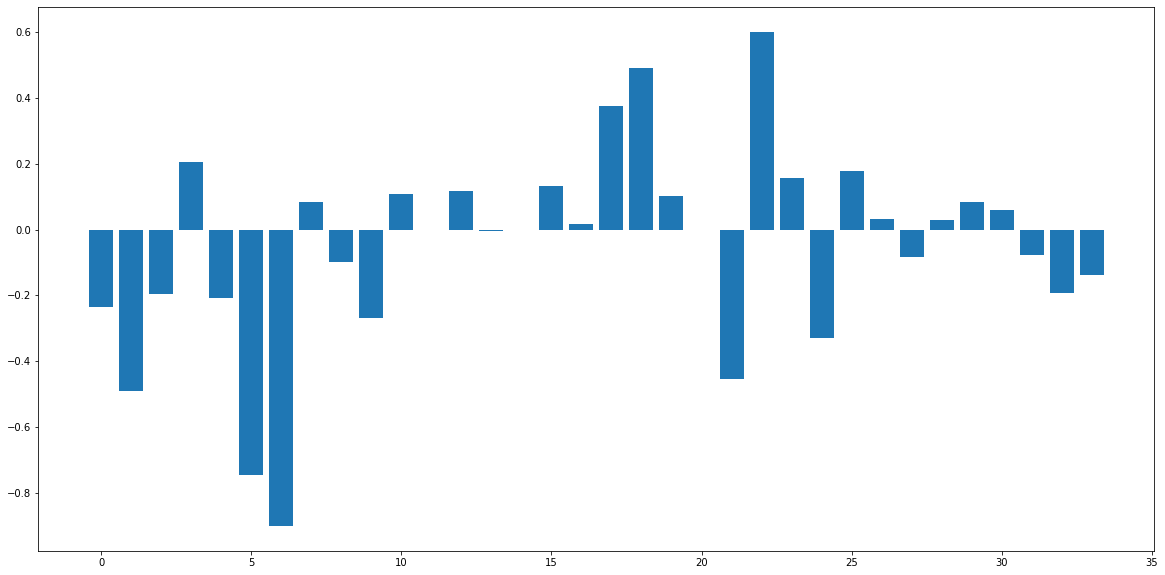

In [63]:
importance = lr_model[1].coef_[0]
# summarize feature importance
feature_scores = []
for i,v in enumerate(importance):
    # print(X.columns[i] + ', Score: %.5f' % v)
    feature_scores.append((X.columns[i], v))

feature_scores = dict(feature_scores)
# plot feature importance
fig, ax = plt.subplots(figsize=(20, 10))
plt.bar([x for x in range(len(importance))], importance)
plt.show()

In [64]:
feature_scores

{'Age': -0.2341921324854003,
 'SibSp': -0.4905908010172056,
 'Parch': -0.19709630395010627,
 'Fare': 0.20501743806261685,
 'Pclass_2': -0.20713524352006504,
 'Pclass_3': -0.7449380866595445,
 'Sex_male': -0.8999919101040464,
 'Embarked_Q': 0.08268781387312805,
 'Embarked_S': -0.09909140981542788,
 'Title_Col.': -0.2686193221295334,
 'Title_Countess': 0.10894943133819138,
 'Title_Don.': 0.0,
 'Title_Dona.': 0.115880657807511,
 'Title_Dr.': -0.004046381843245175,
 'Title_Jonkheer.': 0.0,
 'Title_Lady.': 0.1310079643949558,
 'Title_Major.': 0.016806755731278208,
 'Title_Master.': 0.37403161532898427,
 'Title_Miss.': 0.49083933475376645,
 'Title_Mlle.': 0.10150896558159252,
 'Title_Mme.': 0.0,
 'Title_Mr.': -0.45335272671340393,
 'Title_Mrs.': 0.5998290992418358,
 'Title_Ms.': 0.15642900726494405,
 'Title_Rev.': -0.3297180330072655,
 'Title_Sir.': 0.17902278962408422,
 'Cabin_section_B': 0.03290019115422507,
 'Cabin_section_C': -0.0844801593668724,
 'Cabin_section_D': 0.02823914362617676,


In [65]:
# Print a list of the top 10 predictive features (based on magnitude of the parameters/coefficients fit to scaled data) in the Logistic Regression model as well as their coefficients

top_10 = []

for feature, score in feature_scores.items():
    
    top_10.sort(key=lambda x: np.abs(x[1]), reverse = True)
    
    if len(top_10) < 10:
        top_10.append((feature, score))
    elif (np.abs(score) > np.abs(top_10[9][1])):
        top_10.remove(top_10[9])
        top_10.append((feature, score))
        
    top_10.sort(key=lambda x: np.abs(x[1]), reverse = True)

top_10

[('Sex_male', -0.8999919101040464),
 ('Pclass_3', -0.7449380866595445),
 ('Title_Mrs.', 0.5998290992418358),
 ('Title_Miss.', 0.49083933475376645),
 ('SibSp', -0.4905908010172056),
 ('Title_Mr.', -0.45335272671340393),
 ('Title_Master.', 0.37403161532898427),
 ('Title_Rev.', -0.3297180330072655),
 ('Title_Col.', -0.2686193221295334),
 ('Age', -0.2341921324854003)]

In [ ]:
# From these parameters:
    # Men were less likely to survive (as seen by Sex_male and Title_Mr.)
    # People who bought a 3rd class ticket were less likely to survive (as seen by Pclass_3)
    # Older people were less likely to survive
    # Title Master refers to young boys, and they had a higher chance of surviving